## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt

## Preparación de Datos para Regresión

In [2]:
# Leer el CSV
data = pd.read_csv('../../data/EstudioCrediticio_TrainP.csv')

# Eliminar la primera columna
data = data.iloc[:, 1:]
# Eliminar la penúltima columna
data = data.iloc[:, :-2].join(data.iloc[:, -1])

# Separar las características (X) y la variable a predecir (y)
X = data.iloc[:, :-1]  # Todas las columnas menos la última
y = data.iloc[:, -1]   # La última columna

# Identificar columnas numéricas y categóricas
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear Regression

### Creación de Pipelines

Se crearán las siguientes Pipelines para el preprocesado de los datos:
- En las variables categóricas, se aplicará un imputado basado en la moda y un OneHotEncoder para conseguir arrays numéricos
- En las variables numéricas, se aplicará un imputado basado en la media y se escalarán las variables con PowerTransformer, que aplica una transformación de potencia para hacer que los datos sean más gaussianos, reduciendo el impacto de los outliers. Se usará el método yeo-johnson al tener valores positivos y negativos.

In [8]:
# Pipeline para variables categóricas (Imputación + OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con el valor más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline para variables numéricas (Imputación + Escalado)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar con la media
    ('scaler', PowerTransformer(method='yeo-johnson')), # Escalar debido a outliers
])

# Combinación de transformaciones para columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

En segundo lugar, nos preguntamos: ¿Cuál es el **mejor modelo de regresión Lineal**?

Se usará una Pipelina final que une el **preprocesamiento** de datos con el **regresor**, y posteriormente se realizará **validación cruzada** para comprobar que modelo de regresión lineal da mejor rendimiento. Se probará con _LinearRegression()_, _Ridge()_ que incluye penalización L2, _Lasso()_ que incluye regularización L1, y _ElasticNet()_ que utiliza ambas penalizaciones.

In [10]:
models = [LinearRegression(), Ridge(), Lasso(), ElasticNet()]

for regressor in models:
    # Crear pipeline final con preprocesamiento y modelo
    model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
    ])

    # Definir la estrategia de validación cruzada con KFold
    kfold = KFold(n_splits=5, shuffle=True, random_state=73)

    # Usar cross_val_score para evaluar el modelo utilizando KFold
    results = cross_val_score(model, X, y, cv=kfold, scoring='r2')

    # Mostrar los resultados
    print(f'Accuracy promedio {model.named_steps['regressor']}: {results.mean()}')

Accuracy promedio LinearRegression(): 0.7663280613901761
Accuracy promedio Ridge(): 0.7663297722718247
Accuracy promedio Lasso(): 0.621180007511583
Accuracy promedio ElasticNet(): 0.620506526531895


Se observa que tanto la Regresión Lineal como Ridge ofrecen un rendimiento similar y funcionan mejor en nuestro conjunto de datos. No obstante, los resultados obtenidos no son satisfactorios.

### Evaluación del modelo mediante train, test y métricas

También podemos obtener métricas como la raíz del error cuadrático medio o el error absoluto medio además del R^2 score.

Para ello, dividimos el conjunto de datos en train y test, entranamos y evaluamos.

Usaremos en este caso la Regresión Lineal:

In [11]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
    ])

# Entrenar el modelo
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  Index(['Edad', 'IngresoBrutoAnual', 'ScoreCrediticio', 'Experiencia',
       'CuantiaCredito', 'DuracionCredito', 'NumeroPersonasDependientes',
       'PagoMensualDeuda', 'TasaUtilizacionTarjetaCredito',
       'NumeroLineasCreditoAb...
       'TipoInteres', 'PagoMensualCredito', 'RatioTotalDeudaIngresos'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['SituacionLaboral', 'NivelEducativo', 'EstadoCivil', 'EstadoVivienda',
       'ObjetoCredito'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

In [12]:
y_pred = model.predict(X_test)

# Calcular métricas para regresión
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

RMSE: 3.867989791705261
MAE: 3.20657275390625
R²: 0.7614386669915587


## Ensemble: Random Forest Regressor

Se desarrollarán las pipelines utilizando el mismo enfoque que en el modelo anterior. Sin embargo, a diferencia de este, el PowerTransformer() u otro escalador no son necesarios, ya que los árboles de decisión no se ven influenciados por la escala de las variables.

In [3]:
# Pipeline para variables categóricas (Imputación + OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con el valor más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline para variables numéricas (Imputación + Escalado)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar con la media
])

# Combinación de transformaciones para columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Crear pipeline final con preprocesamiento y modelo
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=73))
])

Se realizará un Randomized Search para encontrar los **mejores hiperparámetros** para nuestro RandomForest.

En este caso, la búsqueda será muy lenta, y el hiperparámetro que nos interesa conocer el número de estimadores (árboles de decisión) que utilizará el random forest.

**GridSearch VS Randomized Search**: 
La diferencia radice en el tiempo de ejecución. Para el mismo espacio de parámetros, el RandomizedSearch selecciona un conjunto de combinaciones al azar a partir del espacio de búsqueda que defines, reduciendo drásticamente el tiempo necesario a cambio de un rendimiento similar o levemente peor. Además, ambos utilizan por defecto **validación cruzada** de 5 folds.

In [6]:
# Definir el espacio de búsqueda para RandomizedSearchCV
param_dist = {
    'regressor__n_estimators': [100, 200, 300, 400, 500],
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    model,                                    # Pipeline
    param_distributions=param_dist,           # Hiperparámetros (espacio de búsqueda)
    verbose=1,                                # Mostrar progreso en la consola
    n_jobs=-1,                                # Usar todos los núcleos disponibles
    random_state=73                           # Reproducibilidad
)

random_search.fit(X_train, y_train)

# Mejores hiperparámetros
print("Mejores parámetros:", random_search.best_params_)

c:\Users\guigr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejores parámetros: {'regressor__n_estimators': 500}


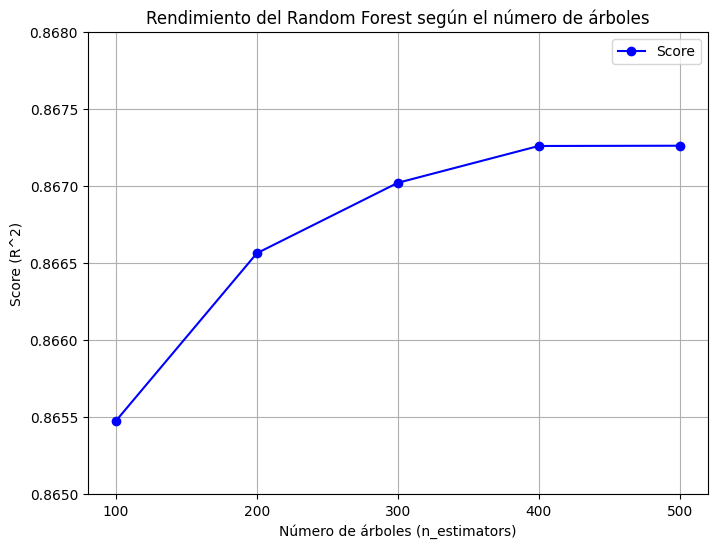

In [17]:
scores = random_search.cv_results_['mean_test_score']
params = [100, 200, 300, 400, 500]

# Crear el gráfico
plt.figure(figsize=(8, 6))
plt.plot(params, scores, marker='o', linestyle='-', color='b', label='Score')
plt.title('Rendimiento del Random Forest según el número de árboles')
plt.xlabel('Número de árboles (n_estimators)')
plt.ylabel('Score (R^2)')
plt.grid(True)
plt.xticks(params)
plt.ylim(0.865, 0.868)
plt.legend()

Podemos comprobar que el error se estabiliza entorno a los 300 estimadores. En otras palabras, con un número mayor de estimadores no se obtienen mejores resultados.

ESTUDIO OOB

Por ello, entrenaremos un modelo con dichos hiperparámetros y observaremos su rendimiento en test de la misma forma que en el modelo anterior.

In [18]:
# Crear pipeline final con preprocesamiento y modelo
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=73, n_estimators=300))
])

# Ajustar el modelo
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['Edad', 'IngresoBrutoAnual', 'ScoreCrediticio', 'Experiencia',
       'CuantiaCredito', 'DuracionCredito', 'NumeroPersonasDependientes',
       'PagoMensualDeuda', 'TasaUtilizacionTarjetaCredito',
       'NumeroLineasCreditoAbiertas', 'NumeroSolicitudesCred...
       'TipoInteres', 'PagoMensualCredito', 'RatioTotalDeudaIngresos'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['SituacionLaboral', 'NivelEducativo', 'EstadoCivil', 'EstadoVivienda',
       'ObjetoCredito'],
      dtype='object'))])),
                ('regressor',
                 RandomForestRegressor(n_estimators=300, random_state=73))])

In [20]:
# Evaluar el modelo
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"R² del conjunto de train: {train_score:.4f}")
print(f"R² del conjunto de test: {test_score:.4f}")

y_pred = model.predict(X_test)

# Calcular métricas para regresión
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE de test: {rmse}")
print(f"MAE de test: {mae}")

R² del conjunto de train: 0.9823
R² del conjunto de test: 0.8675
RMSE de test: 2.8823304862096113
MAE de test: 1.7377754666666667


## Ensemble: Boosting

Para comenzar, probaremos a simple vista qué modelo funciona mejor entre AdaBoostRegressor, GrandientBoostingRegressor y HistGradientBoostingRegressor.

In [5]:
# Pipeline para variables categóricas (Imputación + OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con el valor más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# Pipeline para variables numéricas (Imputación + Escalado)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar con la media
    ('scaler', PowerTransformer(method='yeo-johnson')), # Escalar debido a outliers
])

# Combinación de transformaciones para columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [62]:
models = [AdaBoostRegressor(), GradientBoostingRegressor(), HistGradientBoostingRegressor()]

for regressor in models:
    # Crear pipeline final con preprocesamiento y modelo
    model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
    ])

    # Definir la estrategia de validación cruzada con KFold
    kfold = KFold(n_splits=5, shuffle=True, random_state=73)

    # Usar cross_val_score para evaluar el modelo utilizando KFold
    results = cross_val_score(model, X, y, cv=kfold, scoring='r2')

    # Mostrar los resultados
    print(f'Accuracy promedio {model.named_steps['regressor']}: {results.mean()}')

Accuracy promedio AdaBoostRegressor(): 0.6147926839405948
Accuracy promedio GradientBoostingRegressor(): 0.8662128831201631
Accuracy promedio HistGradientBoostingRegressor(): 0.8963140241289576


Se puede observar que el _HistGradientBoostingRegressor()_ obtiene el mejor rendimiento. Además, este estimador tiene **soporte nativo para valores faltantes** (NaN), por lo que no sería necesario aplicar los imputadores en las Pipelines, y es mucho **más rápido** en conjuntos grandes de datos como el nuestro.

Veamos si el uso de los imputadores empeoraba o no el resultado:

In [64]:
# Pipeline para variables categóricas
categorical_transformer_no_imputer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline para variables numéricas
numeric_transformer_no_imputer = Pipeline(steps=[
    ('scaler', PowerTransformer(method='yeo-johnson')),
])

# Combinación de transformaciones para columnas categóricas y numéricas
preprocessor_no_imputer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_no_imputer, numeric_cols),
        ('cat', categorical_transformer_no_imputer, categorical_cols)
    ])

# Modelo
model_no_imputer = Pipeline(steps=[
    ('preprocessor', preprocessor_no_imputer),
    ('regressor', HistGradientBoostingRegressor())
    ])

# Usar cross_val_score para evaluar el modelo utilizando KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=73)
results = cross_val_score(model_no_imputer, X, y, cv=kfold, scoring='r2')
print(f'R^2 promedio: {results.mean()}')

MAE promedio: 0.8970993762463035


Se comprueba que el uso de los imputadores da el mismo resultado.

De nuevo, realizaremos un RandomizedSearch para obtener los mejores **hiperparámetros**.

In [70]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', HistGradientBoostingRegressor())
    ])

# Definir el espacio de búsqueda para RandomizedSearchCV
param_dist = {
    'regressor__loss': ['squared_error', 'absolute_error', 'poisson'],
    'regressor__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'regressor__max_iter': [100, 200, 300, 400, 500],
    'regressor__max_depth': [5, 10, 15, 20],
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    model,                                    # Pipeline
    param_distributions=param_dist,           # Hiperparámetros (espacio de búsqueda)
    verbose=1,                                # Mostrar progreso en la consola
    n_jobs=-1,                                # Usar todos los núcleos disponibles
    random_state=73                           # Reproducibilidad
)

random_search.fit(X_train, y_train)

# Mejores hiperparámetros
print("Mejores parámetros:", random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores parámetros: {'regressor__max_iter': 200, 'regressor__max_depth': 15, 'regressor__loss': 'poisson', 'regressor__learning_rate': 0.1}


In [71]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', HistGradientBoostingRegressor(max_depth=15, learning_rate=0.1, loss='poisson', max_iter=200))
    ])

# Ajustar el modelo
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  Index(['Edad', 'IngresoBrutoAnual', 'ScoreCrediticio', 'Experiencia',
       'CuantiaCredito', 'DuracionCredito', 'NumeroPersonasDependientes',
       'PagoMensualDeuda', 'TasaUtilizacionTarjetaCredito',
       'NumeroLineasCreditoAb...
       'TipoInteres', 'PagoMensualCredito', 'RatioTotalDeudaIngresos'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['SituacionLaboral', 'NivelEducativo', 'EstadoCivil', 'EstadoVivienda',
       'ObjetoCredito'],
      dtype='object'))])),
                ('regressor',
                 HistGradientBoostingRegressor(loss='poisson', max_depth=15,
                                               max_iter=200))])

In [73]:
# Evaluar el modelo
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"R² del conjunto de entrenamiento: {train_score:.4f}")
print(f"R² del conjunto de prueba: {test_score:.4f}")

y_pred = model.predict(X_test)

# Calcular métricas para regresión
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

R² del conjunto de entrenamiento: 0.9316
R² del conjunto de prueba: 0.8984
RMSE: 2.524270100136954
MAE: 1.665530297968542


De manera adicional, nos gustaría probar el **Extreme Gradient Boosting**. 

XGBoost es una biblioteca separada de sklearn muy optimizada para _Gradient Boosting_, diseñada para ser altamente eficiente, flexible y portátil. Esto se debe a la utilización de métodos como el aprendizaje en paralelo o parámetros de regularización. Gracias a ella podremos hacer un RandomizedSearch con numerosos parámetros y observar sus resultados.

In [11]:
# Crear pipeline final con preprocesamiento y modelo
model = Pipeline(steps=[
('preprocessor', preprocessor),
('regressor', xgb.XGBRegressor(tree_method="hist", random_state=73))
])

param_dist = {
    'regressor__n_estimators': [100, 200, 300, 500, 1000],  # Número de árboles
    'regressor__max_depth': [3, 5, 7, 9, 10],               # Profundidad máxima de los árboles
    'regressor__eta': [0.01, 0.05, 0.1, 0.2, 0.3],          # Tasa de aprendizaje (learning rate)
    'regressor__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],      # Fracción de muestras utilizadas en cada árbol
    'regressor__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0] # Fracción de columnas utilizadas en cada árbol
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    model,                                    # Pipeline
    param_distributions=param_dist,           # Hiperparámetros (espacio de búsqueda)
    verbose=1,                                # Mostrar progreso en la consola
    n_jobs=-1,                                # Usar todos los núcleos disponibles
    random_state=73                           # Reproducibilidad
)

random_search.fit(X_train, y_train)

# Mejores hiperparámetros
print("Mejor puntaje de validación cruzada:", random_search.best_score_)
print("Mejores parámetros:", random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejor puntaje de validación cruzada: 0.901596464098706
Mejores parámetros: {'regressor__subsample': 0.7, 'regressor__n_estimators': 500, 'regressor__max_depth': 5, 'regressor__eta': 0.05, 'regressor__colsample_bytree': 0.8}


Aunque hemos conseguido una mejora muy leve, nos ha costado poco tiempo.

## MLP Regressor

Por último, probaremos con una red neuronal MLPRegressor (perceptrón multicapa). En ella, es necesario normalizar e imputar los valores faltantes.

In [3]:
# Pipeline para variables categóricas (Imputación + OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con el valor más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# Pipeline para variables numéricas (Imputación + Escalado)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar con la media
    ('scaler', PowerTransformer(method='yeo-johnson')), # Escalar debido a outliers
])

# Combinación de transformaciones para columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

De nuevo, realizaremos un RandomizedSearch para obtener los mejores **hiperparámetros**.

In [17]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor())
    ])

# Configurar RandomizedSearchCV
param_dist = {
    'regressor__hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64), (128, 64, 32)],
    'regressor__activation': ['tanh', 'relu'],
    'regressor__solver': ['adam', 'sgd'],
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    model,                                    # Pipeline
    param_distributions=param_dist,           # Hiperparámetros (espacio de búsqueda)
    n_iter=50,                                # Número de combinaciones aleatorias a probar
    verbose=1,                                # Mostrar progreso en la consola
    n_jobs=-1,                                # Usar todos los núcleos disponibles
    random_state=73                           # Reproducibilidad
)

random_search.fit(X_train, y_train)

# Mejores hiperparámetros
print("Mejor puntaje de validación cruzada:", random_search.best_score_)
print("Mejores parámetros:", random_search.best_params_)

C:\Users\guigr\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 20 is smaller than n_iter=50. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejor puntaje de validación cruzada: 0.9204333698582813
Mejores parámetros: {'regressor__solver': 'sgd', 'regressor__hidden_layer_sizes': (64,), 'regressor__activation': 'tanh'}


C:\Users\guigr\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Ahora, haremos validación cruzada con el modelo de MLP con los mejores hiperparámetros obtenido:

In [18]:
# Modelo
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh'))
    ])

# Usar cross_val_score para evaluar el modelo utilizando KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=73)
results = cross_val_score(model, X, y, cv=kfold, scoring='r2')
print(f'R^2 promedio: {results.mean()}')

C:\Users\guigr\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\guigr\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\guigr\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\guigr\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.wa

R^2 promedio: 0.9227317629677841


C:\Users\guigr\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Podemos comprobar que se obtiene un R^2 score de 0.92 con los mejores hiperparámetros. Sin embargo, recibimos un aviso que nos indica que el optimizador (en este caso, sgd), no converge en 200 iteraciones (épocas). Por ello, vamos a realizar otro RandomizedSearch para encontrar el mejor número de _max_iter_. Dependiendo del resultado de la validación cruzada del siguiente RandomizedSearch se usará o no un número mayor de épocas (max_iter).

In [21]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh'))
    ])

# Configurar RandomizedSearchCV
param_dist = {
    'regressor__max_iter': (200, 400, 600, 800, 1000),
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    model,                                    # Pipeline
    param_distributions=param_dist,           # Hiperparámetros (espacio de búsqueda)
    verbose=1,                                # Mostrar progreso en la consola
    n_jobs=-1,                                # Usar todos los núcleos disponibles
    random_state=73                           # Reproducibilidad
)

random_search.fit(X_train, y_train)

# Mejores hiperparámetros
print("Mejor puntaje de validación cruzada:", random_search.best_score_)
print("Mejores parámetros:", random_search.best_params_)

C:\Users\guigr\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejor puntaje de validación cruzada: 0.9213191109365596
Mejores parámetros: {'regressor__max_iter': 600}


El modelo obtiene casi el mismo rendimiento en validación cruzada que cuando usaba 200 iteraciones en vez de 600 iteraciones, por lo que se usarán 200 iteraciones.

In [4]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh', max_iter=200))
    ])

# Ajustar el modelo
model.fit(X_train, y_train)

C:\Users\guigr\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  Index(['Edad', 'IngresoBrutoAnual', 'ScoreCrediticio', 'Experiencia',
       'CuantiaCredito', 'DuracionCredito', 'NumeroPersonasDependientes',
       'PagoMensualDeuda', 'TasaUtilizacionTarjetaCredito',
       'NumeroLineasCreditoAb...
       'TipoInteres', 'PagoMensualCredito', 'RatioTotalDeudaIngresos'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['SituacionLaboral', 'NivelEducativo', 'EstadoCivil', 'EstadoVivienda',
       'ObjetoCredito'],
      dtype='object'))])),
                ('regressor',
                 MLPRegressor(activation='tanh', hidden_layer_sizes=(64,),
                              solver='sgd'))])

In [5]:
# Evaluar el modelo
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"R² del conjunto de entrenamiento: {train_score:.4f}")
print(f"R² del conjunto de prueba: {test_score:.4f}")

y_pred = model.predict(X_test)

# Calcular métricas para regresión
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

R² del conjunto de entrenamiento: 0.9345
R² del conjunto de prueba: 0.9228
RMSE: 2.2010032508736543
MAE: 1.4051506890798389


¿Red Neuronal de Keras?